# Scaling Analysis for TowerLLM models

This notebooks explores using *scaling laws* to analyse, compare and predict the behaviour of the TowerLLM model. 

Understanding these laws can help us make informed decisions about different training regimes and choices (such as data mixtures, positional embeddings, etc.)

## Loading Data

We starting be loading the necessary (evaluation) data for different models trained.

**NOTE**: This assumed this data evaluation data has been generated using official ducttape pipelines.
For example, for CroissantLLM runs in *JeanZay*, you would pass `/gpfswork/rech/hxz/ued79zb/croissllm-outs-v2/Eval/`

In [1]:
import os
import json
import pandas as pd

def crawl_ducttape_outputs(
    ducttape_output: str,
    results_task: str = "Eval",
    results_json: str = "eval_results",
    use_symlinks: bool = True,
):
    """Crawl the outputs of ducttape jobs"""
    results_dir = os.path.join(ducttape_output, results_task)
    branches_info = []
    for filename in os.listdir(results_dir):
        # check if its not directory
        filepath = os.path.join(results_dir, filename)
        if os.path.isfile(filepath):
            continue
        
        branches = filename.split("+")
        kwargs = {
            branch.split(".")[0]: branch.split(".")[1] 
            for branch in branches
        }

        branches_info.append((filepath, kwargs))

    num_branches = max(len(i[1]) for i in branches_info)
    results = []
    for filepath, kwargs in branches_info:
        # skip folders with less branches (so we dont repeat on symlinks)
        if len(kwargs) < num_branches and use_symlinks:
            continue

        # read results
        result_file = os.path.join(filepath, results_json)
        if not os.path.isfile(result_file):
            print(f"Missing results file: {result_file}")
            continue
        
        with open(os.path.join(filepath, results_json)) as f:
            metrics = json.load(f)
            row = {**kwargs, **metrics}
            results.append(row)

    return pd.DataFrame.from_records(results)

In [4]:
MODEL_OUTS = "/home/patrick/croissllm-evalouts/"
output_df = crawl_ducttape_outputs(MODEL_OUTS, use_symlinks=False)
output_df

Missing results file: /home/patrick/croissllm-evalouts/Eval/DataMix.frplus+EvalIteration.340k+Size.small4+UseExternal.true/eval_results
Missing results file: /home/patrick/croissllm-evalouts/Eval/EvalIteration.360k+Size.small2+UseExternal.true/eval_results
Missing results file: /home/patrick/croissllm-evalouts/Eval/DataMix.frplus+EvalIteration.340k+EvalSet.code+Size.small4+UseExternal.true/eval_results
Missing results file: /home/patrick/croissllm-evalouts/Eval/DataMix.enplus+EvalExternal.true+EvalIteration.200k+EvalSet.french_wiki+Size.small2/eval_results
Missing results file: /home/patrick/croissllm-evalouts/Eval/DataMix.enplus+EvalExternal.true+EvalIteration.200k+EvalSet.english+Size.small3/eval_results
Missing results file: /home/patrick/croissllm-evalouts/Eval/EvalIteration.360k+EvalSet.french_wiki+Size.small2+UseExternal.true/eval_results
Missing results file: /home/patrick/croissllm-evalouts/Eval/DataMix.enplus+EvalExternal.true+EvalIteration.200k+EvalSet.french_oscar+Size.small

,DataMix,EvalExternal,EvalIteration,EvalSet,Size,loss,ppl,ajusted_ppl,token_ratio,UseExternal
0,frplus,true,200k,code,small2,1.185493,3.272298,9.686463,1.915431,NaN
1,enplus,NaN,360k,NaN,small2,2.777579,16.080037,34.072140,1.270344,true
2,NaN,NaN,420k,NaN,small4,2.504337,12.235439,24.079692,1.270344,true
3,enplus,NaN,420k,english,small4,2.472285,11.849495,61.632281,1.666954,true
4,enplus,NaN,360k,french_oscar,small4,2.186000,8.899545,34.627847,1.621527,true
...,...,...,...,...,...,...,...,...,...,...
258,frplus,NaN,420k,french_wiki,small4,2.244115,9.432066,44.043455,1.686712,true
259,enplus,NaN,420k,NaN,small4,2.439851,11.471332,22.185743,1.270344,true
260,frplus,NaN,340k,french_oscar,small1,2.649937,14.153142,73.474886,1.621527,true
261,NaN,NaN,360k,english,small4,2.577300,13.161549,73.423192,1.666954,true


In [6]:
# replace NaNs with some and get of fixed step
# output_df['EvalSet'] = output_df['EvalSet'].fillna('wiki')
STEP="500k"
output_df['DataMix'] = output_df['DataMix'].fillna('equal')
output_df['EvalIteration'] = output_df['EvalIteration'].fillna('500k')
output_df = output_df[output_df['EvalIteration'] == STEP]
output_df['EvalSet'] = output_df['EvalSet'].fillna('wiki')
output_df['Size'] = output_df['Size'].fillna('base')
output_df

/tmp/ipykernel_15467/3140565854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['DataMix'] = output_df['DataMix'].fillna('equal')
/tmp/ipykernel_15467/3140565854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['EvalIteration'] = output_df['EvalIteration'].fillna('500k')


,DataMix,EvalExternal,EvalIteration,EvalSet,Size,loss,ppl,ajusted_ppl,token_ratio,UseExternal
5,frplus,NaN,500k,french_wiki,small1,2.827213,16.898304,117.765556,1.686712,NaN
9,enplus,NaN,500k,french_oscar,small3,2.209263,9.108997,35.958981,1.621527,NaN
10,equal,NaN,500k,french_oscar,base,1.703725,5.494376,15.841549,1.621527,true
18,equal,NaN,500k,english,small2,2.787866,16.246315,104.297193,1.666954,NaN
19,enplus,NaN,500k,french_oscar,small1,2.771719,15.986083,89.515898,1.621527,NaN
...,...,...,...,...,...,...,...,...,...,...
216,frplus,NaN,500k,english,small3,2.723246,15.229672,93.646311,1.666954,NaN
223,equal,NaN,500k,english,small4,2.509752,12.301876,65.604250,1.666954,NaN
227,enplus,NaN,500k,wiki,small2,2.735934,15.424147,32.316481,1.270344,NaN
229,equal,NaN,500k,code,base,0.845680,2.329561,5.052287,1.915431,true


In [7]:
output_df[(output_df['Size'] == 'base') & (output_df['EvalSet'] == 'wiki')]

,DataMix,EvalExternal,EvalIteration,EvalSet,Size,loss,ppl,ajusted_ppl,token_ratio,UseExternal
213,equal,NaN,500k,wiki,base,2.244218,9.433039,17.30385,1.270344,true


In [8]:
import yaml

CONFIGS_FOLDER = "../configs/models"
SIZE_CONFIGS = {
    "base": os.path.join(CONFIGS_FOLDER, "llama2_1b3.yml"),
    "small4": os.path.join(CONFIGS_FOLDER, "llama2_440m.yml"),
    "small3": os.path.join(CONFIGS_FOLDER, "llama2_268m.yml"),
    "small2": os.path.join(CONFIGS_FOLDER, "llama2_166m.yml"),
    "small1": os.path.join(CONFIGS_FOLDER, "llama2_58m.yml"),
}

def get_size(
    hidden_size,
    ffn_hidden_size,
    num_layers,
    num_attention_heads,
    num_kv_heads,
    *args,
    vocab_size=32000,
    return_embeddings=True,
    **kwargs,
):
    embeddings_ps = vocab_size * hidden_size
    grouped_size = hidden_size // (num_attention_heads // num_kv_heads)
    layer_attn_ps = hidden_size * hidden_size * 2  + grouped_size * hidden_size * 2
    layer_ffn_ps = hidden_size * ffn_hidden_size * 3
    layer_ln_ps = hidden_size * 2
    layer_ps = layer_attn_ps + layer_ffn_ps + layer_ln_ps
    decoder_ps = hidden_size * vocab_size 

    total_ps = num_layers * layer_ps 
    if return_embeddings:
        total_ps += embeddings_ps + decoder_ps
    return total_ps

def get_scaling_df(output_df):
    df = output_df.copy()
    def _get_size_from_name(name):
        config_f = SIZE_CONFIGS[name]
        with open(config_f) as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        return get_size(**config, return_embeddings=False)
        
    df["Params"] = df["Size"].apply(_get_size_from_name)
    # order columns to have Size and Params first, and sort by Params
    df = df[["Size", "Params"] + [c for c in df.columns if c not in ["Size", "Params"]]]
    df = df.sort_values("Params")
    return df

In [9]:
scaling_df = get_scaling_df(output_df)
scaling_df

,Size,Params,DataMix,EvalExternal,EvalIteration,EvalSet,loss,ppl,ajusted_ppl,token_ratio,UseExternal
5,small1,25171968,frplus,NaN,500k,french_wiki,2.827213,16.898304,117.765556,1.686712,NaN
117,small1,25171968,equal,NaN,500k,english,3.104032,22.287635,176.669059,1.666954,NaN
120,small1,25171968,enplus,NaN,500k,code,1.233415,3.432931,10.617679,1.915431,NaN
130,small1,25171968,equal,NaN,500k,french_oscar,2.653721,14.206802,73.927145,1.621527,NaN
131,small1,25171968,enplus,NaN,500k,french_wiki,2.932698,18.778231,140.698395,1.686712,NaN
...,...,...,...,...,...,...,...,...,...,...,...
25,base,1214349312,equal,NaN,500k,french_wiki,2.023500,7.564753,30.358061,1.686712,true
10,base,1214349312,equal,NaN,500k,french_oscar,1.703725,5.494376,15.841549,1.621527,true
213,base,1214349312,equal,NaN,500k,wiki,2.244218,9.433039,17.303850,1.270344,true
229,base,1214349312,equal,NaN,500k,code,0.845680,2.329561,5.052287,1.915431,true


In [12]:
scaling_df[scaling_df['EvalSet'] == 'english']

,Size,Params,DataMix,EvalExternal,EvalIteration,EvalSet,loss,ppl,ajusted_ppl,token_ratio,UseExternal
199,small1,25171968,enplus,NaN,500k,english,3.020653,20.504682,153.744136,1.666954,NaN
149,small1,25171968,frplus,NaN,500k,english,3.227393,25.213843,217.003984,1.666954,NaN
115,small1,25171968,equal,NaN,500k,english,3.104032,22.287635,176.669059,1.666954,NaN
205,small2,100675584,enplus,NaN,500k,english,2.717677,15.145094,92.781008,1.666954,NaN
17,small2,100675584,equal,NaN,500k,english,2.787866,16.246315,104.297193,1.666954,NaN
96,small2,100675584,frplus,NaN,500k,english,2.900293,18.179465,125.795092,1.666954,NaN
209,small3,202530816,equal,NaN,500k,english,2.615946,13.680156,78.308957,1.666954,NaN
213,small3,202530816,frplus,NaN,500k,english,2.723246,15.229672,93.646311,1.666954,NaN
130,small3,202530816,enplus,NaN,500k,english,2.546947,12.768057,69.800604,1.666954,NaN
98,small4,341544960,frplus,NaN,500k,english,2.613720,13.649736,78.018910,1.666954,NaN


# Scaling Laws

## Core Functions

In [10]:
import scipy.optimize
import numpy as np
from functools import partial

def least_squares(fn, dict0, *args, **kwargs):
  """ 
  Auxiliary function that allows passing dictionary parameters to 
  scipy.optimize.least_squares. Adapted from: 
  https://stackoverflow.com/questions/70673646/passing-a-dictonary-to-scipy-optimize-least-squares
  """ 
  keys = list(dict0.keys());
  if 'bounds' in kwargs and isinstance(kwargs['bounds'], dict):
    kwargs['bounds'] = (
        [kwargs['bounds'][k][0] for k in keys], 
        [kwargs['bounds'][k][1] for k in keys]
    )
  
  result = scipy.optimize.least_squares(
        lambda x, *args, **kwargs: fn({k:v for k,v in zip(keys, x)}, *args, **kwargs), # wrap the argument in a dict
        [dict0[k] for k in keys], # unwrap the initial dictionary
        *args, # pass position arguments
        **kwargs # pass named arguments
  )
  
  # wrap the solution in a dictionary
  try:
    result.x = {k:v for k,v in zip(keys, result.x)}
  except:
    pass

  return result

In [11]:
def ratio_model(coeffs, ps):
  if 'm' in coeffs:
    return coeffs['m'] * (ps - 1) + 1
  elif 'r_1' in coeffs and 'r_2' in coeffs and 'r_3' in coeffs:
    return ps + coeffs['r_1'] * (ps ** coeffs['r_2']) * ((1 - ps) ** coeffs['r_3'])
  else:
    raise ValueError("Unkown ratio aproximator")


def powerlaw(
    coeffs: dict, 
    x: np.array,
    ps: np.array = None,
    x0: int = 10000000,
    shared_alpha: bool=True,
    **kwargs
):
  """
  Applies a powerlaw with coefficients specified in `coeffs`. 
  Note that that `x` is rescaled by 1/x0
  """
  x = (x/x0)
  if ps is None:
    y = coeffs['b'] * np.power(x , -coeffs['alpha'])
  elif isinstance(ps.values[0], str):
    alpha = coeffs['alpha'] if shared_alpha else np.array([coeffs[f'alpha_{p}'] for p in ps])
    bs = np.array([coeffs[f'b_{p}'] for p in ps])
    y = bs * np.power(x , -alpha)
  elif isinstance(ps.values[0], float) or np.issubdtype(type(ps.values[0]), np.integer):
    ratio = ratio_model(coeffs, ps)
    y = coeffs['b'] * np.power(x * ratio, -coeffs['alpha'])
  else:
    raise ValueError(f"Unsupported probability type {ps.values[0]}")

  if 'c' in coeffs:
    y += coeffs['c']

  return y


def residuals(
    coeffs: dict,
    x: np.array, 
    y: np.array,
    ps: np.array = None,
    logspace: bool=False,
    **kwargs: dict
):
  """Computes the residuals of a powerlaw"""
  y_hat = powerlaw(coeffs, x, ps, **kwargs)
  if logspace:
    return y_hat / y - 1
    y_hat = np.log(y_hat)
    y = np.log(y)
  return y_hat - y


def fit_powerlaw(
    x: np.array, 
    y: np.array,
    ps: np.array = None,
    coeffs0: dict = None,
    use_irreducible: bool = True,
    shared_alpha: bool = True,
    bootstrap: bool = False,
    y_std: np.array = None,
    bootstrap_n: int = 100,
    ratio_model="linear",
    f_scale=1.,
    **kwargs: dict
):
  """
  Fits a powerlaw to a x,y pairs of data.
  Returns the fitted coefficients, aswell as the predicted y_hat by the powerlaw
  """
  if coeffs0 is None:
    if ps is None:
      coeffs0 = {
          'b': 1,
          'alpha': 0.15,
      }
      bounds={'b': (-10, 10), 'alpha': (0, 10)}
    elif isinstance(ps.values[0], str):
      keys = set(ps)
      if shared_alpha:
        alphas = {'alpha': 0.15}
        alpha_bound = {'alpha': (0, 10)}
      else:
        alphas =  {f"alpha_{key}": 0.15 for key in keys}
        alpha_bound = {f"alpha_{key}": (0, 10) for key in keys}

      coeffs0 = {
          **{f"b_{key}": 1 for key in keys},
          **alphas,
      }
      bounds={
         **{f"b_{key}": (-10, 10) for key in keys}, 
         **alpha_bound, 
      }
    elif isinstance(ps.values[0], float):
      assert ratio_model is not None
      if ratio_model == "linear":
        coeffs0 = {
            'm': 1,
            'b': 1,
            'alpha': 0.15,
        }
        bounds={'m': (0, 1), 'b': (-10, 10), 'alpha': (0, 10)}
      elif ratio_model == "curve":
        coeffs0 = {
            'r_1': 1,
            'r_2': 1,
            'r_3': 1,
            'b': 1,
            'alpha': 0.15,
        }
        bounds={'r_1': (0, 10), 'r_2': (0, 10), 'r_3': (0, 10), 'b': (-10, 10), 'alpha': (0, 10)}   
    else:
      raise ValueError("Unsupported probability type")
  
  if use_irreducible:
    coeffs0['c'] = 1.
    bounds['c'] = (-10, 10)

  if bootstrap:
    # performs semi-parametric bootstrap resampling
    sampled_coeffs = []
    if y_std is None:
      y_std = 0.01 * y
      
    for i in range(bootstrap_n):
      # for all scales, sample a loss point based on the std error
      y_tilde = np.random.normal(y, y_std)

      # solve
      sol = least_squares(
        partial(residuals, shared_alpha=shared_alpha, **kwargs), coeffs0,
        loss='soft_l1', f_scale=0.1,
        args=(x, y_tilde, ps), max_nfev=10000, 
        bounds=bounds
      )
    
      sampled_coeffs.append(sol.x)

    # compute mean and std for observed coefficients
    sampled_coeffs = {
        k: [cfs[k] for cfs in sampled_coeffs]
        for k in coeffs0.keys()
    }
    coeffs_mean = {k: np.mean(v) for k, v in sampled_coeffs.items()}
    coeffs_std = {k: np.std(v) for k, v in sampled_coeffs.items()}

    y_hat = powerlaw(coeffs_mean, x, ps, shared_alpha=shared_alpha, **kwargs)
    coeffs = (coeffs_mean, coeffs_std)

  else:
    sol = least_squares(
        partial(residuals, shared_alpha=shared_alpha, **kwargs), coeffs0,
        loss='cauchy', f_scale=f_scale,
        args=(x, y, ps), max_nfev=10000, 
        bounds=bounds
    )
    coeffs = sol.x

    y_hat = powerlaw(coeffs, x, ps, shared_alpha=shared_alpha, **kwargs)

  return coeffs, y_hat

## Individual (Per-Lang) Scaling Laws

In [14]:
import numpy as np
from scipy.optimize import curve_fit

# models used to fit scaling laws
include = [
    "small1", 
    "small2", 
    "small3", 
    "small4"
]

# Fit the power laws to the data
laws_params = {}
for grp_name, grp_df in scaling_df.groupby(["DataMix", "EvalSet"]):
    # filter rows that are not in the include list
    grp_df = grp_df[grp_df['Size'].isin(include)]
    
    # Extract the data from the DataFrame
    x_data = grp_df['Params'].values
    y_data = grp_df['loss'].values

    if len(x_data) < 2:
        laws_params[grp_name] = None
        continue

    params, _ = fit_powerlaw(x_data, y_data, use_irreducible=False)
    laws_params[grp_name] = params

for grp_name, params in laws_params.items():
    print(f"fitted params for {grp_name}: {params}")

fitted params for ('enplus', 'code'): {'b': 1.363950078800507, 'alpha': 0.10759614624567836}
fitted params for ('enplus', 'english'): {'b': 3.2612489164784413, 'alpha': 0.0812687158502085}
fitted params for ('enplus', 'french_oscar'): {'b': 3.0735938020034674, 'alpha': 0.10901140968329384}
fitted params for ('enplus', 'french_wiki'): {'b': 3.2025278884961588, 'alpha': 0.09357567184642802}
fitted params for ('enplus', 'wiki'): {'b': 3.330619710188105, 'alpha': 0.08977105549690743}
fitted params for ('equal', 'code'): {'b': 1.3802623518427564, 'alpha': 0.10665261857931763}
fitted params for ('equal', 'english'): {'b': 3.351486190565277, 'alpha': 0.08163855968504583}
fitted params for ('equal', 'french_oscar'): {'b': 2.96994806890089, 'alpha': 0.11912708590382436}
fitted params for ('equal', 'french_wiki'): {'b': 3.126417835434348, 'alpha': 0.09431025260949803}
fitted params for ('equal', 'wiki'): {'b': 3.4425884308655235, 'alpha': 0.09133313965603225}
fitted params for ('frplus', 'code')

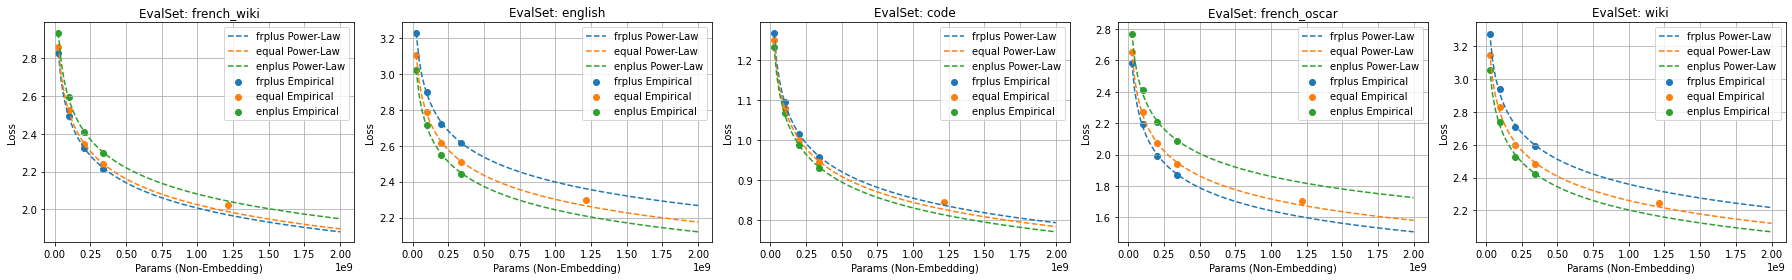

In [15]:
import matplotlib.pyplot as plt

# Generate x values for the fitted curve
# Create a list of unique EvalSets and DataMixes
eval_sets = scaling_df['EvalSet'].unique()
data_mixes = scaling_df['DataMix'].unique()

# Create a color map for the DataMixes
color_map = {data_mix: f'C{i}' for i, data_mix in enumerate(data_mixes)}

# Create a subplot for each EvalSet
x_min, x_max = scaling_df['Params'].min(), 2e9
fig, axs = plt.subplots(1, len(eval_sets), figsize=(5*len(eval_sets), 4))
axs = [axs] if len(eval_sets) == 1 else axs

for ax, eval_set in zip(axs, eval_sets):
    # For each EvalSet, plot the scaling laws and data points for each DataMix
    for data_mix in data_mixes:
        # Filter the DataFrame for the current EvalSet and DataMix
        df = scaling_df[(scaling_df['EvalSet'] == eval_set) & (scaling_df['DataMix'] == data_mix)]
        
        # Extract the data from the DataFrame
        x_data = df['Params'].values
        y_data = df['loss'].values

        # Plot the original data as scatter plot
        ax.scatter(x_data, y_data, color=color_map[data_mix], label=f'{data_mix} Empirical')

        # Compute the y values of the fitted curve
        if (data_mix, eval_set) not in laws_params:
            continue
        params = laws_params[(data_mix, eval_set)]
        if params is None:
            continue
        x_scale = np.linspace(x_min, x_max, 100)
        y_scale = powerlaw(params, x_scale)

        # Plot the fitted curve
        ax.plot(x_scale, y_scale, color=color_map[data_mix], linestyle='--', label=f'{data_mix} Power-Law')

    # Add labels and legend
    ax.set_xlabel('Params (Non-Embedding)')
    ax.set_ylabel('Loss')
    ax.set_title(f'EvalSet: {eval_set}')
    ax.legend()
    ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Joint Scaling Laws

In [16]:
DATAMIX_PROBS = {
    "equal": {"fr": 0.4/0.8, "en": 0.4/0.8},
    "frplus": {"fr": 0.6/0.8, "en": 0.2/0.8},
    "enplus": {"fr": 0.2/0.8, "en": 0.6/0.8},
}
EVALSET_LANGS = {
    "english": "en",
    "wiki": "en",
    "french_wiki": "fr",
    "french_oscar": "fr",
}
RATIO_MODEL = 'curve'

In [26]:
# models used to fit scaling laws
include = [
    "small1",
    "small2", 
    "small3", 
    "small4",
    "base",
]

# Fit the power law to the data
# How to group?
joint_laws_params, ratioed_laws_params = {}, {}
for eval_set, grp_df in scaling_df.groupby(["EvalSet"]):
    if eval_set not in EVALSET_LANGS:
        continue
    
    lang = EVALSET_LANGS[eval_set]

    # filter rows that are not in the include list
    grp_df = grp_df[grp_df['Size'].isin(include)]

    # Extract the data from the DataFrame
    x_data = grp_df['Params']
    y_data = grp_df['loss']
    def _get_prob(row, is_class=False):
        prob = DATAMIX_PROBS[row['DataMix']][lang]
        return f"{prob:.2f}" if is_class else prob
    
    probs = grp_df.apply(_get_prob, axis=1)
    probs_cls = grp_df.apply(partial(_get_prob, is_class=True), axis=1)

    joint_params, _ = fit_powerlaw(
        x_data, y_data, probs_cls,
        shared_alpha=True,
        use_irreducible=True,
    )
    ratioed_params, _ = fit_powerlaw(
        x_data, y_data, probs,
        shared_alpha=True,
        ratio_model=RATIO_MODEL,
        use_irreducible=True,
    )   
    joint_laws_params[eval_set] = joint_params
    ratioed_laws_params[eval_set] = ratioed_params

for grp_name, params in joint_laws_params.items():
    print(f"joint fitted params for {grp_name}: {params}")
    print(f"ratioed fitted params for {grp_name}: {ratioed_laws_params[grp_name]}")

joint fitted params for english: {'b_0.25': 3.045049245987761, 'b_0.75': 2.8146254189794795, 'b_0.50': 2.908094969969734, 'alpha': 0.09556317914763678, 'c': 0.4443828375595659}
ratioed fitted params for english: {'r_1': 0.42437262023223926, 'r_2': 0.5779086483534152, 'r_3': 2.9336435495713546, 'b': 2.7404419115198007, 'alpha': 0.09556311020361036, 'c': 0.444381178514513}
joint fitted params for french_oscar: {'b_0.25': 3.8999741655181834, 'b_0.75': 3.647547086786092, 'b_0.50': 3.7451562771503193, 'alpha': 0.08527773855390997, 'c': -0.810037329383005}
ratioed fitted params for french_oscar: {'r_1': 0.792893115498524, 'r_2': 0.9250534653303703, 'r_3': 2.8175860541768367, 'b': 3.5640581630615427, 'alpha': 0.08527784861959437, 'c': -0.8100333154706306}
joint fitted params for french_wiki: {'b_0.25': 2.7013622405968323, 'b_0.75': 2.579773439303278, 'b_0.50': 2.6189365758705607, 'alpha': 0.11613260056805855, 'c': 0.5114743372077791}
ratioed fitted params for french_wiki: {'r_1': 1.0387410960

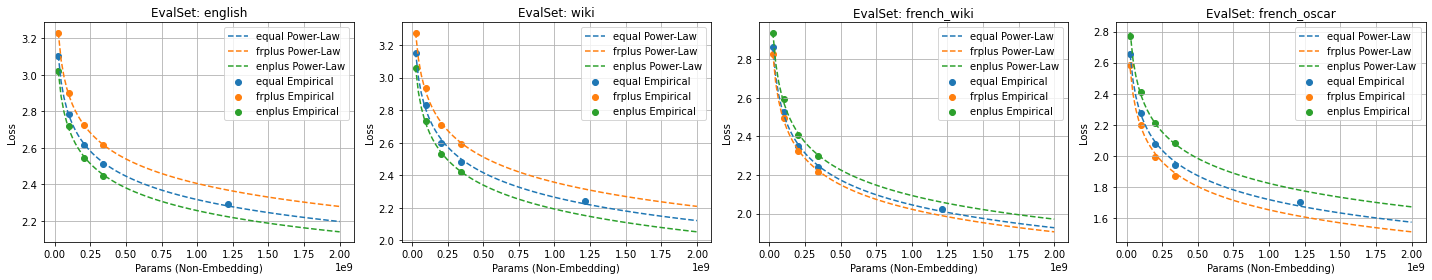

In [27]:
import matplotlib.pyplot as plt

PLOT_RATIO_APPROX = True

# Generate x values for the fitted curve
# Create a list of unique EvalSets and DataMixes
eval_sets = list(EVALSET_LANGS.keys())
data_mixes = list(DATAMIX_PROBS.keys())

# Create a color map for the DataMixes
color_map = {data_mix: f'C{i}' for i, data_mix in enumerate(data_mixes)}

# Create a subplot for each EvalSet
x_min, x_max = scaling_df['Params'].min(), 2e9
fig, axs = plt.subplots(1, len(eval_sets), figsize=(5*len(eval_sets), 4))
axs = [axs] if len(eval_sets) == 1 else axs

for ax, eval_set in zip(axs, eval_sets):
    # For each EvalSet, plot the scaling laws and data points for each DataMix
    for data_mix in data_mixes:
        # Filter the DataFrame for the current EvalSet and DataMix
        df = scaling_df[(scaling_df['EvalSet'] == eval_set) & (scaling_df['DataMix'] == data_mix)]
        
        # Extract the data from the DataFrame
        x_data = df['Params'].values
        y_data = df['loss'].values

        # Plot the original data as scatter plot
        ax.scatter(x_data, y_data, color=color_map[data_mix], label=f'{data_mix} Empirical')

        laws_params = ratioed_laws_params if PLOT_RATIO_APPROX else joint_laws_params
        # Compute the y values of the fitted curve
        if eval_set not in laws_params:
            continue
        params = laws_params[eval_set]
        if params is None:
            continue

        x_scale = np.linspace(x_min, x_max, 100)
        lang = EVALSET_LANGS[eval_set]
        prob = DATAMIX_PROBS[data_mix][lang]
        prob = prob if PLOT_RATIO_APPROX else f"{prob:.2f}"
        probs = np.array([prob] * len(x_scale))
        x_scale = pd.Series(x_scale)
        probs = pd.Series(probs)
        y_scale = powerlaw(params, x_scale, probs, shared_alpha=True)

        # Plot the fitted curve
        ax.plot(x_scale, y_scale, color=color_map[data_mix], linestyle='--', label=f'{data_mix} Power-Law')

    # Add labels and legend
    ax.set_xlabel('Params (Non-Embedding)')
    ax.set_ylabel('Loss')
    ax.set_title(f'EvalSet: {eval_set}')
    ax.legend()
    ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [28]:
PROB_RANGE = [0.1, 0.9]

def effective_params(coeffs, ax=None, color=None, alpha=1., marker=None, label=None):
  from ast import literal_eval as make_tuple
  pairs = {}
  for key in coeffs.keys():
    if not key.startswith("b_"):
      continue
    
    pairs[make_tuple(key[2:])] = coeffs[key]

  ps = sorted(list(pairs.keys()))
  rs = [np.power(pairs[1.] / pairs[p], 1/coeffs['alpha']) for p in ps]
  ax.plot(ps, rs, color=color, label=label)
  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])
  return ps, rs

def ratioed_eff_params(coeffs, ax=None, color=None, alpha=1., marker=None, label=None):
  p = np.linspace(PROB_RANGE[0], PROB_RANGE[1], 100)
  x_scale = pd.Series(p)
  rs = ratio_model(coeffs, x_scale)
  ax.plot(p, rs, color=color, label=label)
  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])
  return p, rs

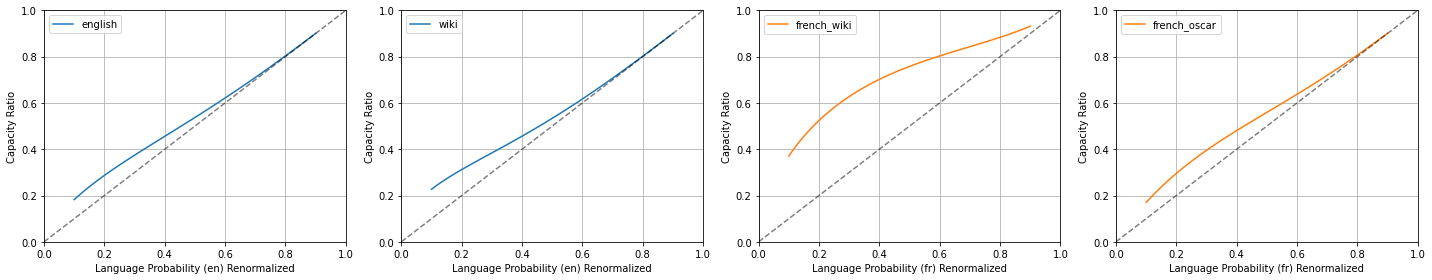

In [29]:
# plot ratio of effective parameters vs language probability

fig, axs = plt.subplots(1, len(eval_sets), figsize=(5*len(eval_sets), 4))
axs = [axs] if len(eval_sets) == 1 else axs

colormap = {"en": "C0", "fr": "C1"}
for ax, eval_set in zip(axs, eval_sets):
    coeffs = ratioed_laws_params[eval_set]
    lang = EVALSET_LANGS[eval_set]
    color = colormap[lang]
    p = np.linspace(PROB_RANGE[0], PROB_RANGE[1], 100)
    x_scale = pd.Series(p)
    rs = ratio_model(coeffs, x_scale)
    ax.plot(p, rs, color=color, label=eval_set)
    # plot identity for reference
    ax.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.5)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel(f"Language Probability ({lang}) Renormalized")
    ax.set_ylabel("Capacity Ratio")
    ax.grid(True)
    ax.legend()

# Show the plot
# add white background
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()
